### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging



# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


# Used for making the graph to visualize our problem
# import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat":False, # if consider the ship squatting while moving, set to True, otherwise set to False 
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "P_hotel_perc": 0.05,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
C_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years



### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(C_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
4795,2020,3.5,7.841206
4796,2020,3.5,7.880905
4797,2020,3.5,7.920603
4798,2020,3.5,7.960302
4799,2020,3.5,8.000000


In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    C_year = row['C_year']
    data_vessel_i = data_vessel.copy()
    data_vessel_i['C_year'] = C_year
    vessel = TransportResource(**data_vessel_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required(V_s)
    vessel.emission_factors_general()
    vessel.correction_factors(V_s)
    vessel.calculate_emission_factors_total(V_s)
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_km'] = Fuel_g_m * 1000
    result['emission_g_km_CO2'] = emission_g_m_CO2 * 1000
    result['emission_g_km_PM10'] = emission_g_m_PM10 * 1000
    result['emission_g_km_NOX'] = emission_g_m_NOX * 1000
    results.append(result)

15it [00:00, 147.45it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0

49it [00:00, 160.75it/s]


10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


83it [00:00, 164.52it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


117it [00:00, 164.92it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


134it [00:00, 161.24it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


167it [00:01, 147.93it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


182it [00:01, 135.30it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


211it [00:01, 133.43it/s]

10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


246it [00:01, 150.95it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


279it [00:01, 154.45it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


312it [00:02, 156.44it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


328it [00:02, 156.28it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


360it [00:02, 141.12it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


375it [00:02, 130.01it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


402it [00:02, 121.70it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


437it [00:02, 144.65it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


472it [00:03, 157.41it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


489it [00:03, 159.35it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


523it [00:03, 161.82it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


556it [00:03, 139.50it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


571it [00:03, 130.95it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


585it [00:04, 124.60it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


613it [00:04, 125.59it/s]

5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


644it [00:04, 128.09it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


674it [00:04, 136.06it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


706it [00:04, 144.89it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


721it [00:05, 133.90it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


735it [00:05, 122.84it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


760it [00:05, 112.98it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


784it [00:05, 109.86it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


812it [00:05, 122.30it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


848it [00:06, 147.95it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


883it [00:06, 160.28it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


900it [00:06, 160.34it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


934it [00:06, 159.49it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


966it [00:06, 146.63it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


981it [00:06, 136.37it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1009it [00:07, 130.90it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1043it [00:07, 146.30it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1059it [00:07, 150.05it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1093it [00:07, 155.37it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1125it [00:07, 155.78it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1157it [00:08, 145.87it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1172it [00:08, 135.77it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1200it [00:08, 126.37it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0


1234it [00:08, 143.28it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1251it [00:08, 148.25it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1284it [00:09, 154.19it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1316it [00:09, 155.60it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1332it [00:09, 152.12it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1362it [00:09, 126.51it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1375it [00:09, 120.19it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1400it [00:09, 113.34it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1433it [00:10, 135.48it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1466it [00:10, 148.15it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1498it [00:10, 153.59it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1514it [00:10, 149.41it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1544it [00:10, 127.89it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1558it [00:11, 122.49it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1584it [00:11, 115.93it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1612it [00:11, 124.66it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1647it [00:11, 146.44it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1665it [00:11, 154.93it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1698it [00:12, 157.53it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1730it [00:12, 155.63it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1762it [00:12, 145.78it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1777it [00:12, 133.11it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1804it [00:12, 123.00it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1836it [00:13, 139.08it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1852it [00:13, 143.80it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1884it [00:13, 149.60it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1916it [00:13, 152.07it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1948it [00:13, 150.79it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1964it [00:13, 137.49it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1992it [00:14, 123.90it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2021it [00:14, 132.16it/s]

7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2055it [00:14, 149.12it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2073it [00:14, 156.13it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2108it [00:14, 160.43it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2141it [00:15, 148.58it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2156it [00:15, 136.58it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2184it [00:15, 120.87it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2197it [00:15, 117.23it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2231it [00:15, 141.64it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2265it [00:16, 152.32it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2300it [00:16, 160.37it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2317it [00:16, 152.88it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2348it [00:16, 132.81it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2362it [00:16, 127.80it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2388it [00:17, 121.85it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2418it [00:17, 131.54it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2435it [00:17, 141.25it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2471it [00:17, 156.83it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2504it [00:17, 159.01it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2536it [00:17, 157.48it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2552it [00:18, 152.81it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2583it [00:18, 133.17it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2612it [00:18, 132.00it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2628it [00:18, 139.48it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2662it [00:18, 150.84it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2695it [00:19, 156.69it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2727it [00:19, 157.61it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2743it [00:19, 154.36it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2774it [00:19, 134.74it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2788it [00:19, 129.47it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0


2820it [00:19, 139.31it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2856it [00:20, 154.79it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2892it [00:20, 164.98it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2926it [00:20, 162.64it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2943it [00:20, 148.01it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2974it [00:21, 131.46it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2988it [00:21, 127.04it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3019it [00:21, 139.17it/s]

5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3056it [00:21, 157.82it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3092it [00:21, 165.83it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3109it [00:21, 165.73it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3142it [00:22, 139.35it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3157it [00:22, 132.27it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3184it [00:22, 117.53it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3196it [00:22, 116.72it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3231it [00:22, 142.00it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3267it [00:23, 159.41it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3302it [00:23, 160.55it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3337it [00:23, 165.54it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3354it [00:23, 164.72it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3371it [00:23, 150.24it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3401it [00:23, 124.47it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3434it [00:24, 141.76it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3467it [00:24, 150.19it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3485it [00:24, 156.93it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3521it [00:24, 165.37it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3555it [00:24, 153.75it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3571it [00:25, 140.61it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3600it [00:25, 128.33it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3634it [00:25, 145.99it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3668it [00:25, 153.75it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3685it [00:25, 157.57it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3720it [00:26, 164.23it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3737it [00:26, 159.28it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3769it [00:26, 133.30it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3796it [00:26, 120.12it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3811it [00:26, 126.67it/s]

5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3846it [00:27, 147.73it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3880it [00:27, 154.38it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3913it [00:27, 151.89it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3929it [00:27, 137.76it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3958it [00:27, 123.73it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3971it [00:27, 121.98it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3997it [00:28, 119.12it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0


4031it [00:28, 139.83it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4066it [00:28, 155.76it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4082it [00:28, 156.89it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4117it [00:28, 164.32it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4151it [00:29, 165.49it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4168it [00:29, 153.01it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4199it [00:29, 133.04it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5


4235it [00:29, 151.62it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4253it [00:29, 158.43it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4289it [00:30, 167.82it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4325it [00:30, 170.03it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4360it [00:30, 152.44it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4376it [00:30, 141.25it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4405it [00:30, 133.25it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4423it [00:30, 144.26it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4459it [00:31, 160.67it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4495it [00:31, 168.62it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4531it [00:31, 168.69it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4548it [00:31, 151.30it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4579it [00:31, 132.77it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4593it [00:32, 127.67it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5


4627it [00:32, 145.30it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4663it [00:32, 160.46it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4699it [00:32, 167.20it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4716it [00:32, 158.13it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4747it [00:33, 133.37it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4761it [00:33, 119.70it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4786it [00:33, 111.58it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4800it [00:33, 142.75it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(100)

,C_year,h_0,V_s,P_installed,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_km,emission_g_km_CO2,emission_g_km_PM10,emission_g_km_NOX,V_s_km
0,1970.0,10.0,0.100000,2200.0,0.034195,0.003647,2.338200e-88,0.012007,0.049849,110.008794,89763.890386,288772.345241,447.357222,6039.353504,0.360000
1,1970.0,10.0,0.139698,2200.0,0.062944,0.006714,1.351710e-64,0.023392,0.093049,110.022931,64263.439925,206736.853544,320.258018,4323.541119,0.502915
2,1970.0,10.0,0.179397,2200.0,0.099453,0.010608,5.948859e-51,0.038507,0.148568,110.047018,50053.283455,161022.477839,249.425060,3367.330738,0.645829
3,1970.0,10.0,0.219095,2200.0,0.143433,0.015299,4.713176e-42,0.057335,0.216066,110.083511,40997.151409,131888.708362,204.276293,2757.864410,0.788744
4,1970.0,10.0,0.258794,2200.0,0.194666,0.020764,9.051534e-36,0.079854,0.295284,110.134808,34723.923329,111707.600155,172.994502,2335.609618,0.931658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1970.0,10.0,3.871357,2200.0,29.124258,3.106485,2.592475e+00,15.008164,49.831381,450.319691,8717.897945,28045.663176,22.942996,382.549435,13.936884
96,1970.0,10.0,3.911055,2200.0,29.684104,3.166200,2.784446e+00,15.285450,50.920200,461.321725,8824.836447,28389.686613,23.127325,386.502162,14.079799
97,1970.0,10.0,3.950754,2200.0,30.248928,3.226445,2.987091e+00,15.564582,52.027047,472.601913,8933.761927,28740.102200,23.311643,390.502161,14.222714
98,1970.0,10.0,3.990452,2200.0,30.818723,3.287222,3.250155e+00,15.907966,53.264066,484.953478,9058.233092,29140.528585,23.523720,395.084111,14.365628


### Run OpenTNSim to Calculate resistance, required power and emissions 
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

### Figures output

### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5, but squatting is disabled)

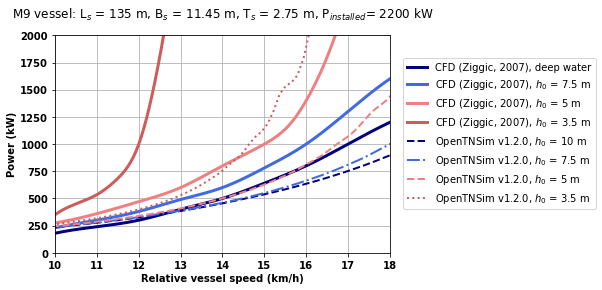

In [9]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)

# selected = plot_df.query('c_year == 1990 and h_0 == 150 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='red',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 50 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='orange',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 20 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='yellow',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Ziggic, 2007), deep water', 'CFD (Ziggic, 2007), $h_0$ = 7.5 m', 'CFD (Ziggic, 2007), $h_0$ = 5 m', 'CFD (Ziggic, 2007), $h_0$ = 3.5 m',
        'OpenTNSim v1.2.0, $h_0$ = 10 m', 'OpenTNSim v1.2.0, $h_0$ = 7.5 m', 'OpenTNSim v1.2.0, $h_0$ = 5 m', 'OpenTNSim v1.2.0, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('total power required versus speed with diff water depths (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW',y=1.05)
plt.savefig('Fig_07_disable_squat.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 
